## SudokuReader

In [ ]:
using Images
using Plots
using Flux
using BSON

In [ ]:
using Revise
Revise.includet("GridDetection/GridDetection.jl")
using .GridDetection
using .GridDetection.PerspectiveTransformations

Revise.includet("DigitDetection/DigitExtraction.jl")
using .DigitExtraction

Revise.includet("utilities/align_centres.jl");

## Load image

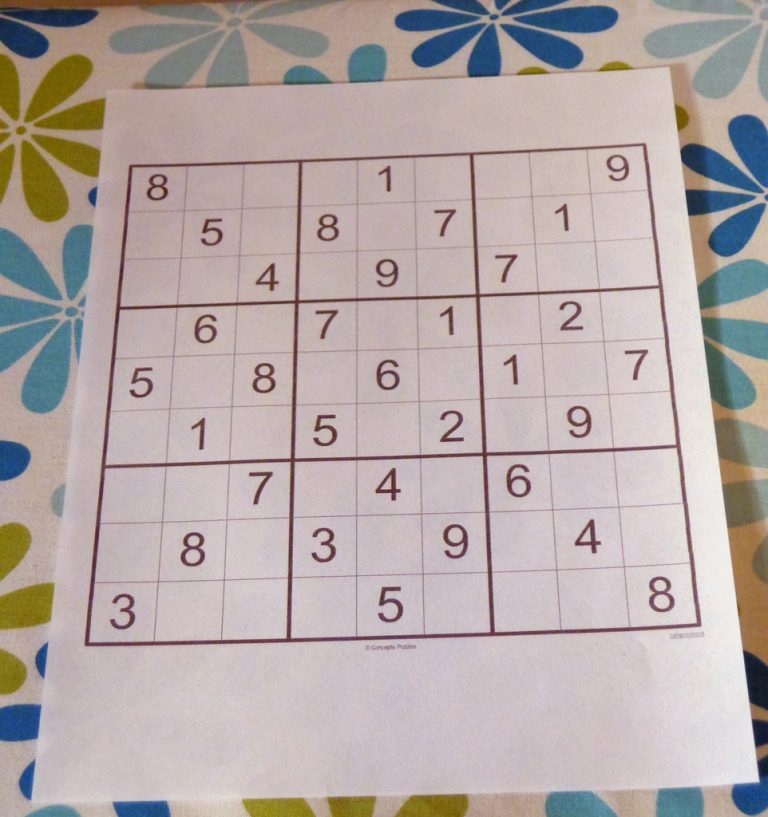

In [ ]:
image_path = "images/sudoku_pyimagesearch.jpg";
image_raw = load(image_path)
image = copy(image_raw)

## Get grid

In [ ]:
blackwhite, quad = detect_grid(
    image; 
    max_size=1024, 
    blur_window_size=5, σ=1.1, 
    threshold_window_size=15, threshold_percentage=7);

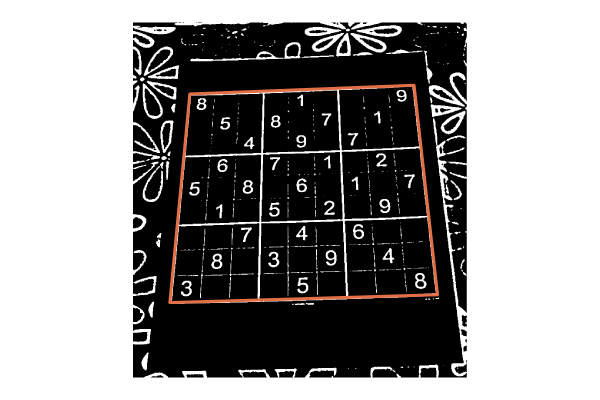

In [ ]:
canvas = plot(blackwhite)

x = [point[2] for point in vcat(quad, quad[1])]
y = [point[1] for point in vcat(quad, quad[1])]
plot!(canvas, x, y, linewidth=3, label="", ticks=:none, border=:none)

## Extract digits

  1.069754 seconds (3.59 M allocations: 184.097 MiB, 84.72% compilation time)


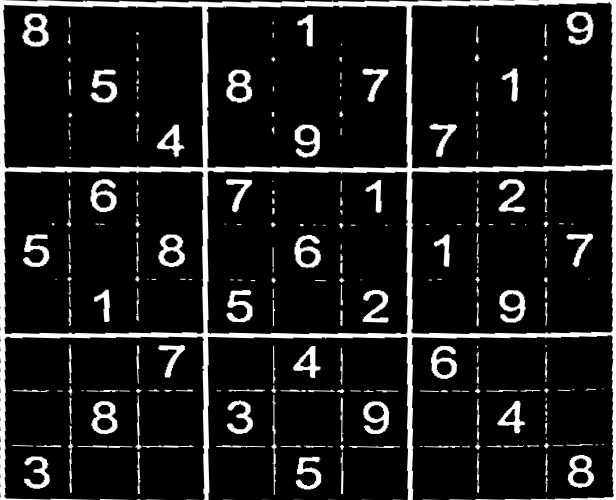

In [ ]:
@time warped, invM = four_point_transform(blackwhite, quad)
warped

In [ ]:
BSON.@load "DigitDetection\\outputs\\LeNet5\\LeNet5_e20.bson" model
model(zeros(Float32, (28, 28, 1, 1))) # compile
model

Chain(
  Conv((5, 5), 1 => 6, relu),           # 156 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 6 => 16, relu),          # 2_416 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(256 => 120, relu),              # 30_840 parameters
  Dense(120 => 84, relu),               # 10_164 parameters
  Dense(84 => 10),                      # 850 parameters
)                   # Total: 10 arrays, 44_426 parameters, 174.867 KiB.

In [ ]:
function predictor(digit_image::AbstractArray)
    logits = digit_image |> DigitExtraction.prepare_digit_for_model |> model
    idx = argmax(logits)
    probabilites = softmax(logits)
    idx[1] - 1, probabilites[idx]
end

predictor (generic function with 1 method)

In [ ]:
grid, centres, probs = extract_digits_from_grid(
    warped, predictor; offset_ratio=0.1, radius_ratio=0.25, threshold=0.1);

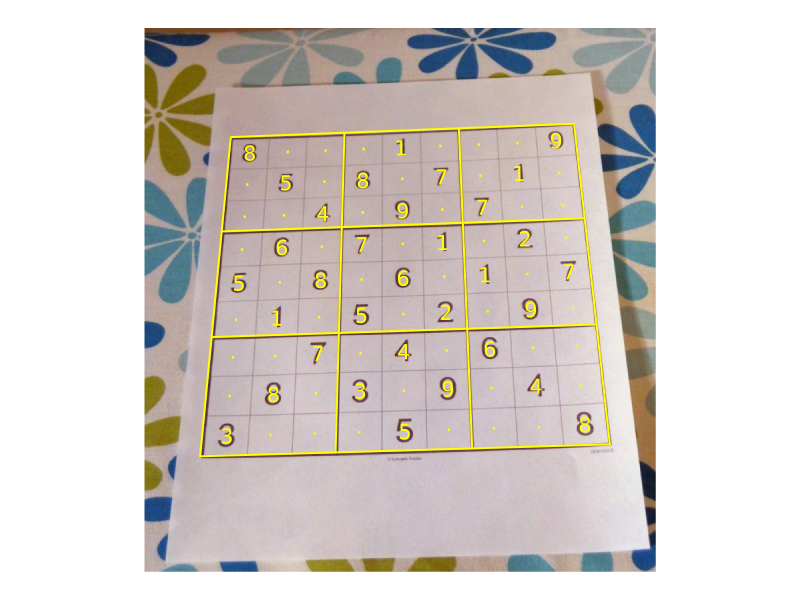

In [ ]:
pred_threshold = 0.0
image_out = imresize(image, size(blackwhite));
canvas = plot(image_out, ticks=nothing, border=:none, size=(800, 600));
color = :yellow

for line in construct_grid(size(warped, 1), size(warped, 2), nblocks=3)
    line_unwarped = map(point -> perspective_transform(invM)(point), line)
    xs = [point[2] for point in line_unwarped]
    ys = [point[1] for point in line_unwarped]
    plot!(canvas, xs, ys, label="", linewidth=2, color=color)
end

centres_aligned = align_centres(centres, probs .> pred_threshold)
for i in 1:9
    for j in 1:9
        centre = centres_aligned[i, j]
        centre_unwarped = perspective_transform(invM)(centre)
        label =  (probs[i, j] > pred_threshold) ? string(grid[i, j]) : "·"
        annotate!(canvas, centre_unwarped[2], centre_unwarped[1], label, color)
    end
end
canvas

In [ ]:
filepath, ext = splitext(image_path)
filename = splitpath(filepath)[end]
savefig(canvas, joinpath("images\\outputs", filename * "_read" * ".png"))

"C:\\Users\\sinai\\Documents\\Projects\\Julia projects\\SudokuReader-Julia\\images\\outputs\\sudoku_pyimagesearch_read.png"

## solve puzzle

⚠️ SudokuSolver.jl is not part of this repository. 

In [ ]:
include("../SudokuSolver.jl/Sudokus.jl")
using .Sudokus
include("../SudokuSolver.jl/sudoku_solver.jl")

flush_candidates! (generic function with 2 methods)

In [ ]:
grid_orig = copy(grid)
pred_threshold = 0.90
grid_orig[probs .< pred_threshold] .= 0
solution_set, info = solve_sudoku(grid_orig, all_solutions=false)
if isempty(solution_set)
    println("no solution found!")
    grid_solved = grid
else
    grid_solved = solution_set[1]
end
solution_set

1-element Vector{Matrix{Int64}}:
 [8 7 … 6 9; 9 5 … 1 4; … ; 6 8 … 4 1; 3 4 … 7 8]

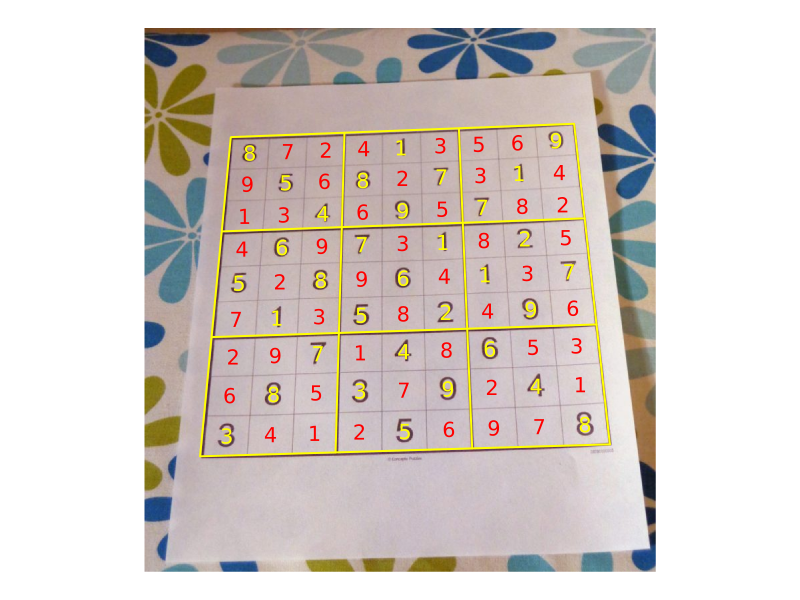

In [ ]:
image_out = imresize(image, size(blackwhite));
canvas = plot(image_out, ticks=nothing, border=:none, size=(800, 600));

for line in construct_grid(size(warped, 1), size(warped, 2))
    line_unwarped = map(point -> perspective_transform(invM)(point), line)
    xs = [point[2] for point in line_unwarped]
    ys = [point[1] for point in line_unwarped]
    plot!(xs, ys, label="", linewidth=2, color=:yellow)
end

centres_aligned = align_centres(centres, grid_orig .> 0)
for i in 1:9
    for j in 1:9
        centre = centres_aligned[i, j]
        centre_unwarped = perspective_transform(invM)(centre)
        color = (grid_orig[i, j] > 0) ? :yellow : :red
        annotate!(canvas, centre_unwarped[2], centre_unwarped[1], string(grid_solved[i, j]), color)
    end
end
canvas

In [ ]:
filepath, ext = splitext(image_path)
filename = splitpath(filepath)[end]
savefig(canvas, joinpath("images\\outputs", filename * "_solved" * ".png"))

"C:\\Users\\sinai\\Documents\\Projects\\Julia projects\\SudokuReader-Julia\\images\\outputs\\sudoku_pyimagesearch_solved.png"